In [1]:
from sympy import symbols
from sympy.physics.mechanics import dynamicsymbols

In [2]:
m1, m2, l1, l2 = symbols("m1, m2, l1, l2")
theta = dynamicsymbols('theta')

# KE
v1, v2 = symbols("v1, v2")
T = (1/2)*m1*v1**2 + (1/2)*m2*v2**2

theta_dot = dynamicsymbols('theta', 1)
# v = omega*r = thetad*l
T = T.subs({v1:theta_dot*l1, v2:theta_dot*l2})
T

0.5*l1**2*m1*Derivative(theta(t), t)**2 + 0.5*l2**2*m2*Derivative(theta(t), t)**2

In [3]:
# PE
h1, h2, g = symbols("h1, h2, g")
V = m1*g*h1 - m2*g*h2

# h = l*sin(theta)
from sympy import sin
V = V.subs({h1: l1*sin(theta), h2:l2*sin(theta)})
V

g*l1*m1*sin(theta(t)) - g*l2*m2*sin(theta(t))

In [4]:
# Lagrangian
L = T - V
L

-g*l1*m1*sin(theta(t)) + g*l2*m2*sin(theta(t)) + 0.5*l1**2*m1*Derivative(theta(t), t)**2 + 0.5*l2**2*m2*Derivative(theta(t), t)**2

In [5]:
from sympy.calculus.euler import euler_equations
eqn = euler_equations(L, theta,)[0]
eqn.simplify()

Eq(g*l1*m1*cos(theta(t)) - g*l2*m2*cos(theta(t)) + 1.0*(l1**2*m1 + l2**2*m2)*Derivative(theta(t), (t, 2)), 0)

In [6]:
from sympy import diff, solve
from sympy import Eq

y = diff(diff(theta))
solution = solve(eqn, y)[0]

Eq(y, solution)


Eq(Derivative(theta(t), (t, 2)), g*(-l1*m1 + l2*m2)*cos(theta(t))/(l1**2*m1 + l2**2*m2))

In [7]:
# Add kinetic and static friction terms
# otherwise the solutions would oscillate indefinitely

delta, mu = symbols('delta, mu')
Eq(y, solution - diff(theta)*delta - mu)

Eq(Derivative(theta(t), (t, 2)), -delta*Derivative(theta(t), t) + g*(-l1*m1 + l2*m2)*cos(theta(t))/(l1**2*m1 + l2**2*m2) - mu)

### Solving for theta

In [28]:
import numpy as np

m1, m2 = 1.5, 2.5 # in kilograms
l1, l2 = 10/100, 7/100 # in meters
g = 9.8
delta = 0.45
mu = 5.5

def theta_double_prime(theta, theta_prime):
    term = g*(-l1*m1 + l2*m2)/(l1**2*m1 + l2**2*m2)
    result = term*np.cos(theta)
    if result.all() != 0:
        # add damping and friction
        return result - delta*(theta_prime) - mu
    else:
        # no damping/friction if already in equilibrium
        return result

from scipy.integrate import solve_ivp

def func(t, y):
    theta, theta_prime = y
    return [theta_prime, theta_double_prime(theta, theta_prime)]

def max_turn(t, y):
    # if turn is -90, the beam touches ground
    # therfore stop integration
    return y[0] + np.deg2rad(90)
max_turn.terminal = True

t_span = [0, 25]
y0 = [np.deg2rad(0), 0]  # start theta, theta_prime

sol = solve_ivp(func, t_span, y0, events=max_turn)

t = sol.t
x = sol.y[0,:]

In [71]:
import seaborn as sns
sns.set_context("paper", font_scale=2.)
sns.set_style('whitegrid')

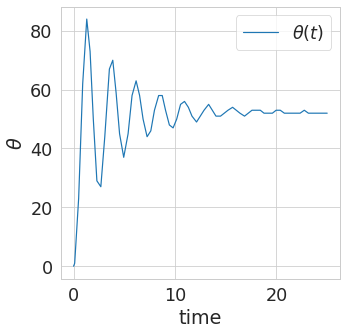

In [72]:
plt.figure(figsize=(5, 5))
ax = sns.lineplot(x=t, y=np.rad2deg(x).round(0), label=r'$\theta(t)$') 
ax.set_xlabel('time')
ax.set_ylabel(r'$\theta$');
plt.savefig('angle.png', bbox_inches='tight', dpi=200);

### Animate beam balance

In [37]:
# Helper functions to rotate mass and points properly
def line_rotation(radius, length, angle):
    # angle in radians
    # returns [x0, x1], [y0, y1] 
    
    x = radius*np.cos(angle)
    y = radius*np.sin(angle)
    return [[x, x], [y, length + radius*np.sin(angle)]]

def point_rotation(x, y, angle):
    # angle in radians
    return np.array([x*np.cos(angle), y + x*np.sin(angle)])

def moments_angled(m1, m2, l1, l2, angle, beam_length=11):
    # angle in deg
    # total length of beam is assumed to be 22 (twice beam_length)
    # and is symmetric along the pivot (0, 0)
    # l1 is to the left and should be negative

    ptsX = np.linspace(-beam_length, 0, 100)
    ptsY = np.linspace(0, beam_length, 100)
    
    # make nan for distances beyond l1, l2
    ptsX[ptsX < l1] = np.nan
    ptsY[ptsY > l2] = np.nan
    
    
    # if balance makes angle with pos. x axis, 
    # the perp. distance from force to origin is 
    # l1*cos(angle)
    # moment = force* perp distance
    g = 9.8
    left_moments = m1*g*ptsX*np.cos(angle)
    right_moments = m2*g*ptsY*np.cos(angle)
    
    return np.concatenate([left_moments, right_moments])

In [57]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib import transforms


def plot_func(i, ax, cax):
    
#     ax = fig.gca()
    angle_rad = x[i]
    angle_deg = np.rad2deg(angle_rad)
    
    left_anchor = -10
    right_anchor = 7
    rope_length = -8
    
    right_thread_point = point_rotation(right_anchor, 0, angle_rad)
    right_thread_rot = line_rotation(right_anchor, rope_length, angle_rad)
    right_weight_rot = point_rotation(right_anchor, rope_length, angle_rad)
    left_thread_point = point_rotation(left_anchor, 0, angle_rad)
    left_thread_rot = line_rotation(left_anchor, rope_length, angle_rad)
    left_weight_rot = point_rotation(left_anchor, rope_length, angle_rad)

    artists = [
        # beam
        mpatches.Rectangle((-11, -1), 22, 2, ec="black", angle=angle_deg, 
                          rotation_point='center', color='white', zorder=0,),
        mpatches.Circle((0, 0), 0.75, ec="black", color='white', zorder=2),
                mlines.Line2D([0, 0], [-0.1, 5], lw=4, color='black', zorder=3), 

        # Left weight
        mpatches.Circle(left_thread_point, 0.5, ec="black", color='white', zorder=4), 
        mpatches.Circle(left_weight_rot, m1, ec="black", color='red', zorder=5),
        mlines.Line2D(left_thread_rot[0], left_thread_rot[1], lw=2, color='black', zorder=6),

        # right weight
        mpatches.Circle(right_thread_point, 0.5, ec="black", color='white', zorder=7), 
        mpatches.Circle(right_weight_rot, m2, ec="black", color='red', zorder=8),
        mlines.Line2D(right_thread_rot[0], right_thread_rot[1], lw=2, color='black', zorder=9),
   
    ]

    for p in artists:
        ax.add_artist(p)

    ax.annotate(f"{m1} kg", xy=left_weight_rot + np.array([1.5, -3]),)
    ax.annotate(f"{m2} kg", xy=right_weight_rot + np.array([3, -3]),)

    # add moments
    mo = moments_angled(m1, m2, left_anchor, right_anchor, angle_deg)
    tr = transforms.Affine2D().rotate_deg(angle_deg)
    im = ax.imshow(np.atleast_2d(mo), extent=[-11,-11+22,-1,-1+2], 
              aspect="auto", zorder=1, cmap='Spectral_r', vmin=-150,
              vmax=150, transform=tr + ax.transData)

    
    ax.set_ylim([-20, 20])
    ax.set_xlim([-20, 20])
    sns.despine(offset=10, trim=True)
    
    # add colour bar
    plt.colorbar(im, cax=cax, orientation='horizontal', 
                 label=r'Moment $(Nm)$', location='top', 
                 ticks=[-150, 0, 150])
    
    plt.tight_layout()

/tmp/ipykernel_1450452/1891320127.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


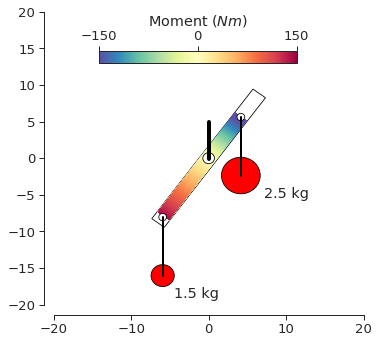

In [74]:
sns.set_context("paper", font_scale=1.5)
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(5.5, 5))
cbar_ax = fig.add_axes([0.27, 0.8, 0.5, 0.035])
plot_func(45, ax, cax=cbar_ax)
plt.savefig('beam.png', bbox_inches='tight', dpi=200)

/tmp/ipykernel_1450452/1891320127.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


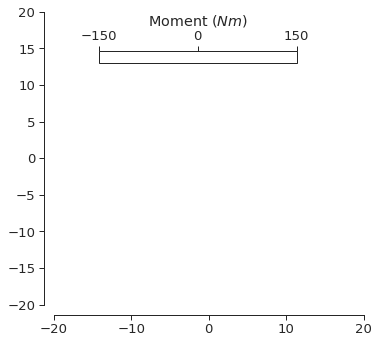

In [68]:
from celluloid import Camera
sns.set_context("paper", font_scale=1.5)
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(5.5, 5))
cbar_ax = fig.add_axes([0.27, 0.8, 0.5, 0.035])

camera = Camera(fig)
for i in range(0, x.shape[0]-1):
    plot_func(i, ax, cbar_ax)
    camera.snap();
    print(i, end='\r')
animation = camera.animate();

In [69]:
animation.save('anim_with_moment.mp4', dpi=200)

<video controls src='anim_with_moment.mp4' width='400' height='400'>